In [3]:
import numpy as np
import matplotlib.pyplot as plt

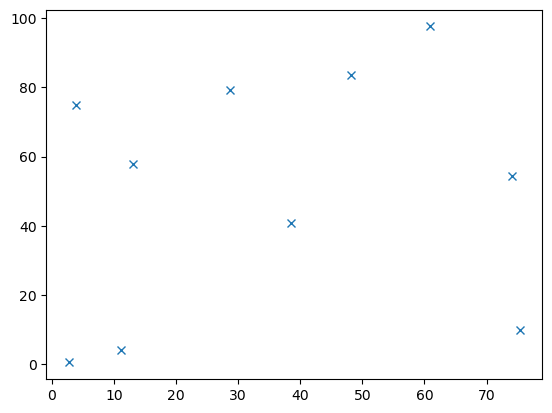

In [6]:
# Map
seed = 1338
x_dim, y_dim = 100, 100
landmarks = np.random.RandomState(seed).rand(10, 2) * np.array([x_dim, y_dim])
landmarks

plt.plot(landmarks[:, 0], landmarks[:, 1], 'x')

In [ ]:
# wanted trajectory


In [ ]:
# EKF SLAM implementation

